In [1]:
import torch
import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

print(torch.__version__)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

from bliss import sleep
from bliss.datasets import simulated

import numpy as np
import time 

torch.manual_seed(184)
np.random.seed(143)

1.7.0


In [2]:
import sys
sys.path.insert(0, './m2_utils/')

import plotting
import m2_data
import summary_statistics

In [3]:
%env BLISS_HOME=/home/runingli/astronomy/celeste/

env: BLISS_HOME=/home/runingli/astronomy/celeste/


# Get config file

In [4]:
overrides = dict(
    model="m2",
    dataset="m2",
    training="m2",
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [5]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

In [6]:
cfg.model.decoder.params.update({'ptile_padding': 6, 
                                 'max_sources': 5})

cfg.model.encoder.params.update({'max_detections': 2})

In [7]:
cfg

{'general': {'overwrite': False}, 'paths': {'root': '${env:BLISS_HOME}', 'output': '${paths.root}/logs/example'}, 'optimizer': {'name': 'torch.optim.Adam', 'params': {'lr': 0.0001, 'weight_decay': 1e-06}}, 'model': {'name': 'SleepPhase', 'image': {'slen': 100, 'n_bands': 2, 'background': [686.0, 1123.0]}, 'galaxy': {'slen': 51, 'latent_dim': 8}, 'decoder': {'params': {'n_bands': '${model.image.n_bands}', 'slen': '${model.image.slen}', 'tile_slen': 2, 'ptile_padding': 6, 'prob_galaxy': 0.0, 'n_galaxy_params': '${model.galaxy.latent_dim}', 'max_sources': 5, 'mean_sources': 0.48, 'min_sources': 0, 'f_min': 1000.0, 'f_max': 1000000.0, 'alpha': 0.5, 'gal_slen': '${model.galaxy.slen}', 'decoder_file': None, 'psf_params_file': '${paths.root}/data/sdss/2583/2/136/psField-002583-2-0136.fit', 'background_values': '${model.image.background}', 'border_padding': 3}}, 'encoder': {'params': {'n_bands': '${model.image.n_bands}', 'tile_slen': '${model.decoder.params.tile_slen}', 'ptile_slen': 8, 'max_d

In [8]:
cfg.optimizer.params.update({'lr': 1e-3, 
                             'weight_decay': 1e-5})

# Load dataset and encoder

In [9]:
datamodule = simulated.SimulatedModule(cfg)
sleep_net = sleep.SleepPhase(cfg)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


### Check priors

Text(0.5, 0, 'n-sources per tile')

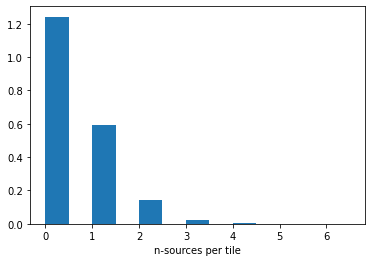

In [10]:
# prior on n-stars

%matplotlib inline

plt.hist(datamodule.dataset.get_batch()['n_sources'].flatten().cpu(), 
         bins=np.arange(7, step = 0.5), 
         density = True);

plt.xlabel('n-sources per tile')

Text(0.5, 0, 'log10(fluxes)')

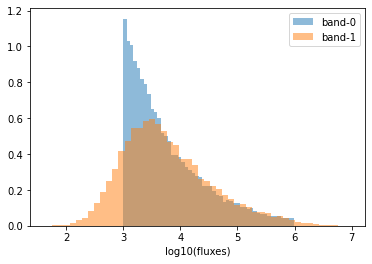

In [11]:
# prior on fluxes

%matplotlib inline

for b in range(2): 
    
    fluxes = datamodule.dataset.get_batch()['fluxes'][:, :, :, b]
    fluxes = fluxes.flatten()
    fluxes = fluxes[fluxes > 0]


    plt.hist(np.log10(fluxes.cpu()), 
                     density = True, 
                     alpha = 0.5, 
                     label = 'band-' + str(b), 
                     bins = 50)
    
plt.legend()

plt.xlabel('log10(fluxes)')

Text(0.5, 0, 'color')

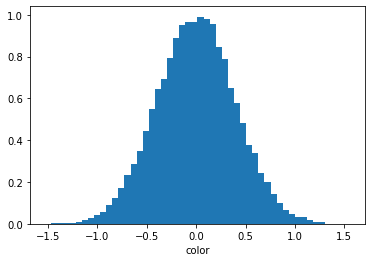

In [12]:
# prior on colors

%matplotlib inline

plt.figure()

fluxes = datamodule.dataset.get_batch()['fluxes']
colors = (torch.log10(fluxes[:, :, :, 1]) - 
           torch.log10(fluxes[:, :, :, 0])).flatten()
colors = colors[fluxes[:, :, :, 0].flatten() > 0]

bins = plt.hist(colors.cpu(), 
                 density = True, bins = 50)

plt.xlabel('color')

# Plot a simulated image

In [13]:
batch = datamodule.dataset.get_batch()

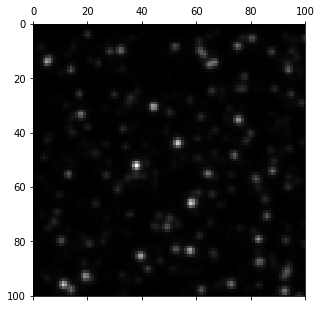

In [14]:
%matplotlib inline

image_indx = 0

image = batch['images'][image_indx, 0].cpu()

f, axarr = plt.subplots(1, 1, figsize=(5, 5))
plotting.plot_image(axarr, image)

### some subimages

In [15]:
slen = datamodule.dataset.image_decoder.slen
border_padding = datamodule.dataset.image_decoder.border_padding

In [16]:
from bliss.models.encoder import get_full_params

In [17]:
# get locations on the full image
full_params = get_full_params(slen, 
                              dict({'n_sources': batch['n_sources'][0:1], 
                                    'locs': batch['locs'][0:1]}))

locs_full = full_params['locs']

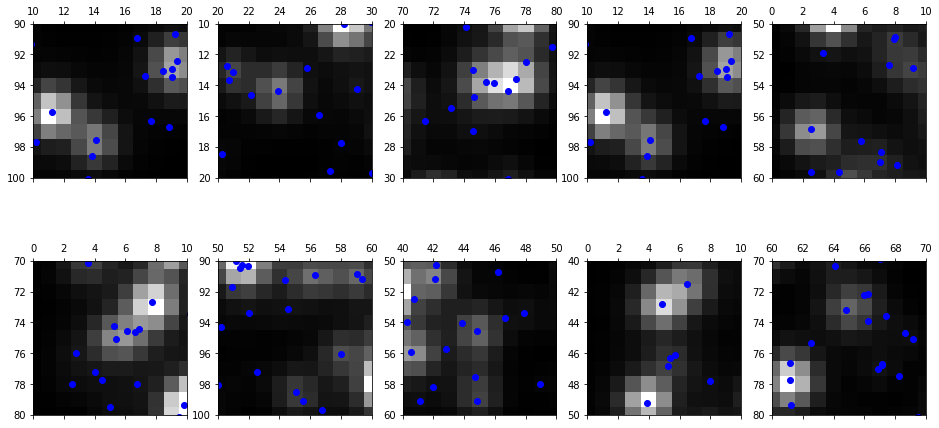

In [18]:
f, axarr = plt.subplots(2, 5, figsize=(16, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(locs_full.squeeze(), slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    
    plotting.plot_image(ax, image, 
               x0, x1, subimage_slen, subimage_slen)


# Train!

In [19]:
t0 = time.time()
trainer.fit(sleep_net, datamodule = datamodule)
torch.save(sleep_net.image_encoder.state_dict(), './starnet')

print('TOTAL TIME ELAPSED: {:.3f}secs'.format(time.time() - t0))

# sleep_net.image_encoder.load_state_dict(torch.load('./starnet')); 


  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 492 K 
1 | image_decoder | ImageDecoder | 12    
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 49: : 10it [00:02,  3.61it/s, loss=0.984]
Validating: 0it [00:00, ?it/s]
Epoch 49: : 11it [00:02,  3.73it/s, loss=0.984]
Epoch 49: : 12it [00:03,  3.84it/s, loss=0.984]
Epoch 49: : 13it [00:03,  3.93it/s, loss=0.984]
Epoch 49: : 14it [00:03,  4.02it/s, loss=0.984]
Epoch 49: : 15it [00:03,  4.09it/s, loss=0.984]
Epoch 49: : 16it [00:03,  4.16it/s, loss=0.984]
Epoch 49: : 17it [00:04,  4.23it/s, loss=0.984]
Epoch 49: : 18it [00:04,  4.28it/s, loss=0.984]
Epoch 49: : 19it [00:04,  4.33it/s, loss=0.984]
Epoch 49: : 20it [00:04,  4.27it/s, loss=0.984]
Epoch 99: : 10it [00:02,  3.64it/s, loss=0.758]
Validating: 0it [00:00, ?it/s]
Epoch 99: : 11it [00:02,  3.73it/s, loss=0.758]
Epoch 99: : 12it [00:03,  3.82it/s, loss=0.758]
Epoch 99: : 13it [00:03,  3.91it/s, loss=0.758]
Epoch 99: : 14it [00:03,  3.99it/s, loss=0.758]
Epoch 99: : 15it [00:03,  4.07it/s, loss=0.758]
Epoch 99: : 16it [00:03,  4.14it/s, loss=0.758]
Epoch 99: : 17it [00:04,  4.20it/s, loss=0.758]
Epoch 99: : 18it [00:04,  

In [20]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

# Results on SDSS data

### Load SDSS data

In [21]:
sdss_image, _, hubble_locs, hubble_fluxes, sdss_data, _ = \
    m2_data.load_m2_data(sdss_dir = '../../data/sdss/',
                        hubble_dir = '../../data/hubble/', 
                        border_padding = border_padding)

nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

loading sdss image from ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../../data/hubble/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-r-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 aligning images. 
 Getting sdss coordinates from:  ../../data/sdss/2583/2/136/frame-i-002583-2-0136.fits

 returning image at x0 = 630, x1 = 310


### get map estiamates

In [22]:
sdss_image.shape

torch.Size([2, 106, 106])

In [23]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_image.unsqueeze(0))

map_nstars = map_estimate['n_sources'].detach()
map_locs = map_estimate['locs'].detach()
map_log_fluxes = map_estimate['log_fluxes'].detach()

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [24]:
print(map_nstars)

tensor([952.], device='cuda:2')


### Example subimages

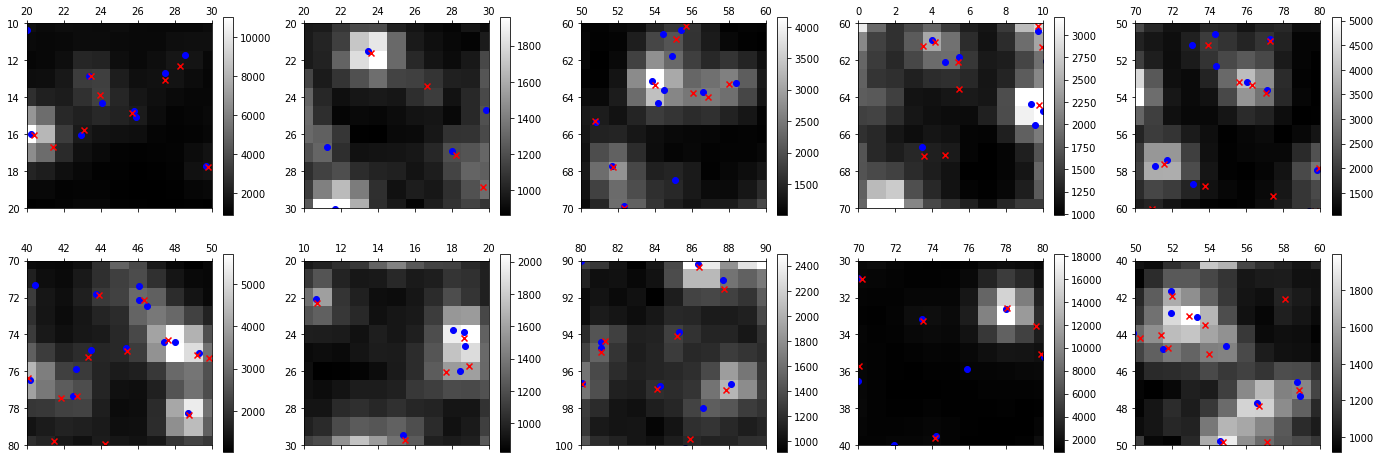

In [25]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(hubble_locs, slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, border_padding, 
                            ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, sdss_image[0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

### Summary statistics

In [26]:
tpr, ppv = summary_statistics.get_summary_stats(map_locs.squeeze(), 
                                                hubble_locs, 
                                                slen, 
                                                map_log_fluxes.exp()[0, :, 0], 
                                                hubble_fluxes[:, 0],
                                                nelec_per_nmgy = nelec_per_nmgy)[0:2]

print('True positive rate: {:.3f}'.format(tpr))
print('Positive predictive value: {:.3f}'.format(ppv))
print('F1: {:.3f}'.format(2 * tpr * ppv / (tpr + ppv)))

True positive rate: 0.490
Positive predictive value: 0.604
F1: 0.541


In [27]:
# percentiles of the hubble magnitudes.
hubble_mags = summary_statistics.convert_nmgy_to_mag(hubble_fluxes[:, 0] / nelec_per_nmgy)
percentiles = np.linspace(0, 1, 11) * 100
mag_vec = np.percentile(hubble_mags.cpu(), percentiles)
mag_vec = torch.Tensor(mag_vec).to(device)

        
# get tpr as function of magnitude
tpr_vec  = \
    summary_statistics.get_tpr_vec(map_locs.squeeze(), 
                                    hubble_locs, 
                                    slen, 
                                    map_log_fluxes.exp()[0, :, 0], 
                                    hubble_fluxes[:, 0],
                                    nelec_per_nmgy = nelec_per_nmgy, 
                                    mag_vec = mag_vec)[0]

# # get ppv as function of magnitude
ppv_vec  = \
    summary_statistics.get_ppv_vec(map_locs.squeeze(), 
                                    hubble_locs, 
                                    slen, 
                                    map_log_fluxes.exp()[0, :, 0], 
                                    hubble_fluxes[:, 0],
                                    nelec_per_nmgy = nelec_per_nmgy, 
                                    mag_vec = mag_vec)[0]

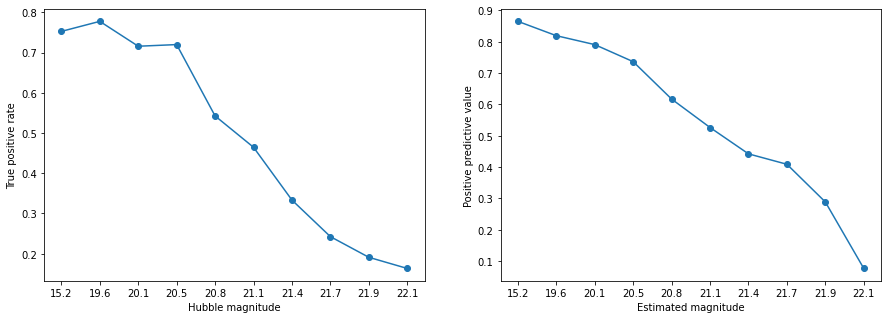

In [28]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))


# plot summary statistics as function of hubble percentile
percentiles = np.linspace(0, 1, 10 + 1) * 100
axarr[0].plot(percentiles[:-1], tpr_vec, '-o')
axarr[1].plot(percentiles[:-1], ppv_vec, '-o')

# axis labels
axarr[0].set_xlabel('Hubble magnitude')
axarr[1].set_xlabel('Estimated magnitude')
axarr[0].set_ylabel('True positive rate')
axarr[1].set_ylabel('Positive predictive value')

# replace percentiles with actual magnitudes
for i in range(2): 
    axarr[i].set_xticks(percentiles[:-1])
    axarr[i].set_xticklabels(np.round(mag_vec.cpu().numpy(), 1)[:-1])


In [29]:
hubble_mags = summary_statistics.convert_nmgy_to_mag(hubble_fluxes[:, 0] / nelec_per_nmgy)
est_mags = summary_statistics.convert_nmgy_to_mag(map_log_fluxes.exp()[0, :, 0] / nelec_per_nmgy)

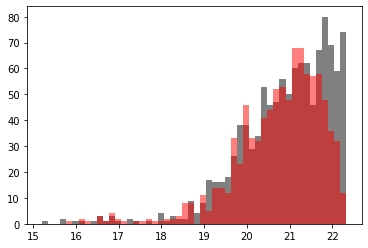

In [30]:
# flux distributions
bins = plt.hist(hubble_mags.cpu(), color = 'grey', bins = 50);
plt.hist(est_mags.cpu(), color = 'red', alpha = 0.5, bins = bins[1]);